In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=1)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR085' 

In [6]:
WuLEVEL = 13
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [450000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-1.65825454e-02 -6.36508486e+05]
Y_MAX [1.61338477e-02 6.30193895e+05]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 27000000.0, 0, 0.1]
X_MAX [1, 29000000.0, 6.0, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

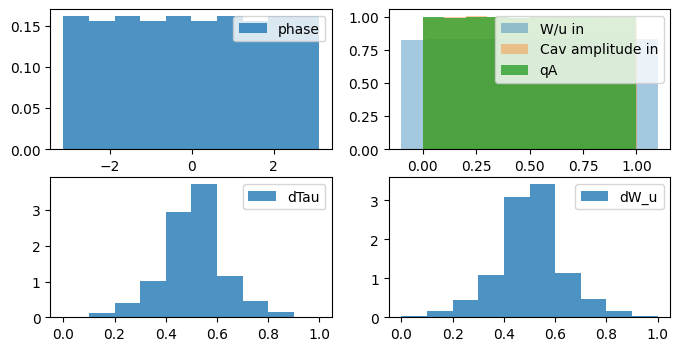

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=1))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 64, 64, 64],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-04-18 17:26
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 6000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL13/model.pt
  - fname_opt: ./WuLEVEL13/optimizer.pt
  - fname_history: ./WuLEVEL13/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:1
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:1
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:1
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:

 Epoch 0067: | Train Loss: 9.47E-08 | Val Loss: 7.06E-08 | lr: 1.92E-05 | 0:31:20.514637
 Epoch 0068: | Train Loss: 9.47E-08 | Val Loss: 7.69E-08 | lr: 1.95E-05 | 0:31:46.290829
 Epoch 0069: | Train Loss: 9.49E-08 | Val Loss: 7.32E-08 | lr: 1.98E-05 | 0:32:12.135573
 Epoch 0070: | Train Loss: 9.52E-08 | Val Loss: 6.64E-08 | lr: 2.01E-05 | 0:32:39.423750
 Epoch 0071: | Train Loss: 9.54E-08 | Val Loss: 6.88E-08 | lr: 2.04E-05 | 0:33:07.420707
 Epoch 0072: | Train Loss: 9.59E-08 | Val Loss: 1.01E-07 | lr: 2.08E-05 | 0:33:34.700186
 Epoch 0073: | Train Loss: 9.63E-08 | Val Loss: 6.69E-08 | lr: 2.11E-05 | 0:34:02.070170
 Epoch 0074: | Train Loss: 9.72E-08 | Val Loss: 1.02E-07 | lr: 2.14E-05 | 0:34:28.962239
 Epoch 0075: | Train Loss: 9.72E-08 | Val Loss: 6.65E-08 | lr: 2.18E-05 | 0:34:55.191304
 Epoch 0076: | Train Loss: 9.83E-08 | Val Loss: 6.40E-08 | lr: 2.21E-05 | 0:35:20.671784
 Epoch 0077: | Train Loss: 9.89E-08 | Val Loss: 6.35E-08 | lr: 2.24E-05 | 0:35:46.469800
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 3.33E-07 | Val Loss: 5.33E-07 | lr: 5.90E-05 | 1:12:54.948097
 Epoch 0161: | Train Loss: 3.36E-07 | Val Loss: 3.80E-07 | lr: 5.94E-05 | 1:13:29.908875
 Epoch 0162: | Train Loss: 3.38E-07 | Val Loss: 5.40E-07 | lr: 5.99E-05 | 1:13:59.805825
 Epoch 0163: | Train Loss: 3.41E-07 | Val Loss: 7.81E-08 | lr: 6.04E-05 | 1:14:32.195555
 Epoch 0164: | Train Loss: 3.45E-07 | Val Loss: 4.61E-07 | lr: 6.09E-05 | 1:14:58.477362
 Epoch 0165: | Train Loss: 3.49E-07 | Val Loss: 8.33E-08 | lr: 6.13E-05 | 1:15:25.258445
 Epoch 0166: | Train Loss: 3.50E-07 | Val Loss: 2.53E-07 | lr: 6.18E-05 | 1:15:56.544908
 Epoch 0167: | Train Loss: 3.54E-07 | Val Loss: 1.74E-07 | lr: 6.23E-05 | 1:16:23.766943
 Epoch 0168: | Train Loss: 3.55E-07 | Val Loss: 4.39E-07 | lr: 6.28E-05 | 1:16:56.944719
 Epoch 0169: | Train Loss: 3.59E-07 | Val Loss: 4.66E-07 | lr: 6.32E-05 | 1:17:24.069250
 Epoch 0170: | Train Loss: 3.60E-07 | Val Loss: 1.04E-07 | lr: 6.37E-05 | 1:17:54.551386
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.55E-07 | Val Loss: 1.18E-06 | lr: 9.46E-05 | 1:57:38.514252
 Epoch 0254: | Train Loss: 3.52E-07 | Val Loss: 1.38E-07 | lr: 9.48E-05 | 1:58:06.489460
 Epoch 0255: | Train Loss: 3.51E-07 | Val Loss: 6.40E-08 | lr: 9.50E-05 | 1:58:41.693832
 Epoch 0256: | Train Loss: 3.48E-07 | Val Loss: 3.03E-07 | lr: 9.52E-05 | 1:59:19.648774
 Epoch 0257: | Train Loss: 3.46E-07 | Val Loss: 1.01E-06 | lr: 9.54E-05 | 1:59:48.370617
 Epoch 0258: | Train Loss: 3.43E-07 | Val Loss: 1.43E-07 | lr: 9.56E-05 | 2:00:16.357098
 Epoch 0259: | Train Loss: 3.42E-07 | Val Loss: 6.67E-08 | lr: 9.58E-05 | 2:00:44.347187
 Epoch 0260: | Train Loss: 3.40E-07 | Val Loss: 2.27E-07 | lr: 9.60E-05 | 2:01:16.441013
 Epoch 0261: | Train Loss: 3.39E-07 | Val Loss: 9.92E-07 | lr: 9.62E-05 | 2:01:49.275919
 Epoch 0262: | Train Loss: 3.36E-07 | Val Loss: 1.07E-07 | lr: 9.64E-05 | 2:02:23.105790
 Epoch 0263: | Train Loss: 3.32E-07 | Val Loss: 9.39E-08 | lr: 9.66E-05 | 2:02:57.061041
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.82E-07 | Val Loss: 1.01E-07 | lr: 1.00E-04 | 2:44:36.102019
 Epoch 0347: | Train Loss: 1.80E-07 | Val Loss: 1.82E-07 | lr: 1.00E-04 | 2:45:02.397723
 Epoch 0348: | Train Loss: 1.79E-07 | Val Loss: 1.81E-07 | lr: 1.00E-04 | 2:45:41.571307
 Epoch 0349: | Train Loss: 1.78E-07 | Val Loss: 2.11E-08 | lr: 1.00E-04 | 2:46:07.455391
 Epoch 0350: | Train Loss: 1.77E-07 | Val Loss: 1.49E-08 | lr: 1.00E-04 | 2:46:34.110148
 Epoch 0351: | Train Loss: 1.75E-07 | Val Loss: 1.83E-08 | lr: 1.00E-04 | 2:47:04.493288
 Epoch 0352: | Train Loss: 1.75E-07 | Val Loss: 1.99E-07 | lr: 1.00E-04 | 2:47:30.136883
 Epoch 0353: | Train Loss: 1.73E-07 | Val Loss: 4.74E-08 | lr: 1.00E-04 | 2:48:02.069244
 Epoch 0354: | Train Loss: 1.73E-07 | Val Loss: 1.40E-07 | lr: 1.00E-04 | 2:48:32.007721
 Epoch 0355: | Train Loss: 1.71E-07 | Val Loss: 1.96E-07 | lr: 1.00E-04 | 2:49:01.376408
 Epoch 0356: | Train Loss: 1.70E-07 | Val Loss: 2.00E-08 | lr: 1.00E-04 | 2:49:26.941074
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.10E-07 | Val Loss: 2.56E-07 | lr: 9.99E-05 | 3:30:34.794615
 Epoch 0440: | Train Loss: 1.11E-07 | Val Loss: 3.80E-07 | lr: 9.99E-05 | 3:31:00.382200
 Epoch 0441: | Train Loss: 1.11E-07 | Val Loss: 3.67E-07 | lr: 9.98E-05 | 3:31:26.441028
 Epoch 0442: | Train Loss: 1.09E-07 | Val Loss: 5.79E-08 | lr: 9.98E-05 | 3:31:55.648334
 Epoch 0443: | Train Loss: 1.09E-07 | Val Loss: 1.17E-07 | lr: 9.98E-05 | 3:32:28.400278
 Epoch 0444: | Train Loss: 1.09E-07 | Val Loss: 5.05E-08 | lr: 9.98E-05 | 3:33:06.255869
 Epoch 0445: | Train Loss: 1.08E-07 | Val Loss: 3.24E-08 | lr: 9.98E-05 | 3:33:38.818514
 Epoch 0446: | Train Loss: 1.08E-07 | Val Loss: 2.11E-08 | lr: 9.98E-05 | 3:34:08.154711
 Epoch 0447: | Train Loss: 1.07E-07 | Val Loss: 1.60E-08 | lr: 9.98E-05 | 3:34:36.884410
 Epoch 0448: | Train Loss: 1.07E-07 | Val Loss: 3.82E-07 | lr: 9.98E-05 | 3:35:09.944109
 Epoch 0449: | Train Loss: 1.06E-07 | Val Loss: 1.10E-08 | lr: 9.98E-05 | 3:35:38.321164
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.35E-08 | Val Loss: 1.22E-07 | lr: 9.96E-05 | 4:13:54.489465
 Epoch 0533: | Train Loss: 7.36E-08 | Val Loss: 3.15E-07 | lr: 9.96E-05 | 4:14:30.301961
 Epoch 0534: | Train Loss: 7.27E-08 | Val Loss: 1.17E-07 | lr: 9.96E-05 | 4:14:59.483747
 Epoch 0535: | Train Loss: 7.29E-08 | Val Loss: 8.96E-08 | lr: 9.96E-05 | 4:15:29.841950
 Epoch 0536: | Train Loss: 7.21E-08 | Val Loss: 2.91E-08 | lr: 9.96E-05 | 4:15:57.864642
 Epoch 0537: | Train Loss: 7.24E-08 | Val Loss: 2.72E-07 | lr: 9.96E-05 | 4:16:23.300132
 Epoch 0538: | Train Loss: 7.16E-08 | Val Loss: 3.78E-08 | lr: 9.96E-05 | 4:16:56.359665
 Epoch 0539: | Train Loss: 7.15E-08 | Val Loss: 1.97E-08 | lr: 9.96E-05 | 4:17:23.074301
 Epoch 0540: | Train Loss: 7.15E-08 | Val Loss: 1.95E-08 | lr: 9.96E-05 | 4:17:54.371150
 Epoch 0541: | Train Loss: 7.06E-08 | Val Loss: 1.13E-08 | lr: 9.96E-05 | 4:18:20.594230
 Epoch 0542: | Train Loss: 7.10E-08 | Val Loss: 1.48E-08 | lr: 9.96E-05 | 4:18:51.036440
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.14E-08 | Val Loss: 8.41E-08 | lr: 9.92E-05 | 4:57:09.076271
 Epoch 0626: | Train Loss: 5.12E-08 | Val Loss: 2.00E-08 | lr: 9.92E-05 | 4:57:41.557230
 Epoch 0627: | Train Loss: 5.08E-08 | Val Loss: 1.87E-07 | lr: 9.92E-05 | 4:58:07.262854
 Epoch 0628: | Train Loss: 5.09E-08 | Val Loss: 3.32E-08 | lr: 9.92E-05 | 4:58:39.081865
 Epoch 0629: | Train Loss: 5.04E-08 | Val Loss: 9.55E-09 | lr: 9.92E-05 | 4:59:10.236212
 Epoch 0630: | Train Loss: 5.05E-08 | Val Loss: 2.61E-08 | lr: 9.92E-05 | 4:59:38.483070
 Epoch 0631: | Train Loss: 5.00E-08 | Val Loss: 3.49E-08 | lr: 9.92E-05 | 5:00:08.254728
 Epoch 0632: | Train Loss: 5.00E-08 | Val Loss: 6.52E-08 | lr: 9.92E-05 | 5:00:37.453571
 Epoch 0633: | Train Loss: 4.99E-08 | Val Loss: 3.02E-08 | lr: 9.92E-05 | 5:01:07.363195
 Epoch 0634: | Train Loss: 4.97E-08 | Val Loss: 7.05E-09 | lr: 9.92E-05 | 5:01:37.557221
 Epoch 0635: | Train Loss: 4.95E-08 | Val Loss: 1.54E-08 | lr: 9.92E-05 | 5:02:10.615018
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.75E-08 | Val Loss: 7.38E-09 | lr: 9.87E-05 | 5:41:42.576325
 Epoch 0719: | Train Loss: 3.75E-08 | Val Loss: 1.05E-07 | lr: 9.87E-05 | 5:42:12.526983
 Epoch 0720: | Train Loss: 3.74E-08 | Val Loss: 1.77E-08 | lr: 9.87E-05 | 5:42:43.816930
 Epoch 0721: | Train Loss: 3.73E-08 | Val Loss: 1.80E-08 | lr: 9.87E-05 | 5:43:13.881011
 Epoch 0722: | Train Loss: 3.71E-08 | Val Loss: 1.92E-08 | lr: 9.87E-05 | 5:43:42.169812
 Epoch 0723: | Train Loss: 3.70E-08 | Val Loss: 6.66E-08 | lr: 9.86E-05 | 5:44:08.067309
 Epoch 0724: | Train Loss: 3.70E-08 | Val Loss: 1.32E-07 | lr: 9.86E-05 | 5:44:44.181548
 Epoch 0725: | Train Loss: 3.69E-08 | Val Loss: 6.52E-09 | lr: 9.86E-05 | 5:45:10.189072
 Epoch 0726: | Train Loss: 3.67E-08 | Val Loss: 3.10E-08 | lr: 9.86E-05 | 5:45:44.765875
 Epoch 0727: | Train Loss: 3.67E-08 | Val Loss: 2.93E-08 | lr: 9.86E-05 | 5:46:12.151453
 Epoch 0728: | Train Loss: 3.64E-08 | Val Loss: 1.46E-08 | lr: 9.86E-05 | 5:46:40.073062
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 2.88E-08 | Val Loss: 6.62E-08 | lr: 9.80E-05 | 6:27:04.256008
 Epoch 0812: | Train Loss: 2.87E-08 | Val Loss: 3.85E-08 | lr: 9.80E-05 | 6:27:31.490396
 Epoch 0813: | Train Loss: 2.86E-08 | Val Loss: 6.77E-09 | lr: 9.80E-05 | 6:27:59.456156
 Epoch 0814: | Train Loss: 2.85E-08 | Val Loss: 4.27E-09 | lr: 9.80E-05 | 6:28:27.035677
 Epoch 0815: | Train Loss: 2.85E-08 | Val Loss: 6.50E-09 | lr: 9.80E-05 | 6:28:55.145335
 Epoch 0816: | Train Loss: 2.83E-08 | Val Loss: 4.86E-09 | lr: 9.80E-05 | 6:29:27.516095
 Epoch 0817: | Train Loss: 2.83E-08 | Val Loss: 2.07E-08 | lr: 9.80E-05 | 6:30:02.465014
 Epoch 0818: | Train Loss: 2.83E-08 | Val Loss: 1.95E-08 | lr: 9.80E-05 | 6:30:28.577566
 Epoch 0819: | Train Loss: 2.81E-08 | Val Loss: 1.09E-08 | lr: 9.80E-05 | 6:30:54.977990
 Epoch 0820: | Train Loss: 2.81E-08 | Val Loss: 7.92E-09 | lr: 9.80E-05 | 6:31:23.220093
 Epoch 0821: | Train Loss: 2.80E-08 | Val Loss: 1.44E-08 | lr: 9.80E-05 | 6:31:57.084856
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.28E-08 | Val Loss: 4.89E-09 | lr: 9.73E-05 | 7:12:29.626197
 Epoch 0905: | Train Loss: 2.26E-08 | Val Loss: 7.08E-09 | lr: 9.72E-05 | 7:12:55.965387
 Epoch 0906: | Train Loss: 2.26E-08 | Val Loss: 1.33E-08 | lr: 9.72E-05 | 7:13:22.309361
 Epoch 0907: | Train Loss: 2.26E-08 | Val Loss: 1.12E-07 | lr: 9.72E-05 | 7:13:49.407774
 Epoch 0908: | Train Loss: 2.26E-08 | Val Loss: 3.04E-08 | lr: 9.72E-05 | 7:14:15.019454
 Epoch 0909: | Train Loss: 2.25E-08 | Val Loss: 7.37E-09 | lr: 9.72E-05 | 7:14:40.773692
 Epoch 0910: | Train Loss: 2.25E-08 | Val Loss: 2.11E-08 | lr: 9.72E-05 | 7:15:09.672609
 Epoch 0911: | Train Loss: 2.23E-08 | Val Loss: 1.53E-08 | lr: 9.72E-05 | 7:15:41.736411
 Epoch 0912: | Train Loss: 2.25E-08 | Val Loss: 5.50E-09 | lr: 9.72E-05 | 7:16:10.197392
 Epoch 0913: | Train Loss: 2.22E-08 | Val Loss: 5.84E-09 | lr: 9.72E-05 | 7:16:37.196869
 Epoch 0914: | Train Loss: 2.23E-08 | Val Loss: 3.49E-09 | lr: 9.72E-05 | 7:17:03.137750
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 1.89E-08 | Val Loss: 2.38E-08 | lr: 9.64E-05 | 7:54:49.708614
 Epoch 0998: | Train Loss: 1.89E-08 | Val Loss: 1.35E-08 | lr: 9.63E-05 | 7:55:16.628198
 Epoch 0999: | Train Loss: 1.87E-08 | Val Loss: 5.47E-08 | lr: 9.63E-05 | 7:55:52.830237
 Epoch 1000: | Train Loss: 1.87E-08 | Val Loss: 7.66E-09 | lr: 9.63E-05 | 7:56:27.187093
 Epoch 1001: | Train Loss: 1.88E-08 | Val Loss: 3.54E-09 | lr: 9.63E-05 | 7:56:56.227516
 Epoch 1002: | Train Loss: 1.87E-08 | Val Loss: 9.63E-09 | lr: 9.63E-05 | 7:57:27.140214
 Epoch 1003: | Train Loss: 1.87E-08 | Val Loss: 3.93E-09 | lr: 9.63E-05 | 7:57:55.974686
 Epoch 1004: | Train Loss: 1.87E-08 | Val Loss: 1.51E-07 | lr: 9.63E-05 | 7:58:28.065686
 Epoch 1005: | Train Loss: 1.86E-08 | Val Loss: 9.44E-09 | lr: 9.63E-05 | 7:58:56.024610
 Epoch 1006: | Train Loss: 1.86E-08 | Val Loss: 9.27E-08 | lr: 9.63E-05 | 7:59:29.339193
 Epoch 1007: | Train Loss: 1.85E-08 | Val Loss: 9.89E-09 | lr: 9.63E-05 | 7:59:59.388695
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.64E-08 | Val Loss: 3.67E-09 | lr: 9.53E-05 | 8:38:43.505718
 Epoch 1091: | Train Loss: 1.63E-08 | Val Loss: 7.53E-09 | lr: 9.53E-05 | 8:39:09.965468
 Epoch 1092: | Train Loss: 1.62E-08 | Val Loss: 4.17E-09 | lr: 9.53E-05 | 8:39:35.362738
 Epoch 1093: | Train Loss: 1.62E-08 | Val Loss: 1.93E-08 | lr: 9.53E-05 | 8:40:00.556061
 Epoch 1094: | Train Loss: 1.62E-08 | Val Loss: 6.88E-09 | lr: 9.53E-05 | 8:40:26.209203
 Epoch 1095: | Train Loss: 1.61E-08 | Val Loss: 3.11E-08 | lr: 9.53E-05 | 8:40:52.948157
 Epoch 1096: | Train Loss: 1.62E-08 | Val Loss: 6.21E-09 | lr: 9.53E-05 | 8:41:18.931291
 Epoch 1097: | Train Loss: 1.62E-08 | Val Loss: 3.12E-08 | lr: 9.53E-05 | 8:41:47.057945
 Epoch 1098: | Train Loss: 1.61E-08 | Val Loss: 1.52E-08 | lr: 9.52E-05 | 8:42:12.680315
 Epoch 1099: | Train Loss: 1.61E-08 | Val Loss: 1.94E-09 | lr: 9.52E-05 | 8:42:44.921715
 Epoch 1100: | Train Loss: 1.61E-08 | Val Loss: 4.70E-08 | lr: 9.52E-05 | 8:43:21.053431
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.43E-08 | Val Loss: 1.16E-08 | lr: 9.42E-05 | 9:22:46.947114
 Epoch 1184: | Train Loss: 1.43E-08 | Val Loss: 6.25E-09 | lr: 9.42E-05 | 9:23:12.469980
 Epoch 1185: | Train Loss: 1.43E-08 | Val Loss: 3.63E-09 | lr: 9.42E-05 | 9:23:43.493118
 Epoch 1186: | Train Loss: 1.42E-08 | Val Loss: 5.23E-09 | lr: 9.42E-05 | 9:24:09.018270
 Epoch 1187: | Train Loss: 1.42E-08 | Val Loss: 4.10E-08 | lr: 9.41E-05 | 9:24:34.549330
 Epoch 1188: | Train Loss: 1.42E-08 | Val Loss: 2.63E-09 | lr: 9.41E-05 | 9:25:00.274381
 Epoch 1189: | Train Loss: 1.42E-08 | Val Loss: 2.57E-09 | lr: 9.41E-05 | 9:25:26.250190
 Epoch 1190: | Train Loss: 1.42E-08 | Val Loss: 6.64E-09 | lr: 9.41E-05 | 9:25:56.996858
 Epoch 1191: | Train Loss: 1.41E-08 | Val Loss: 4.14E-09 | lr: 9.41E-05 | 9:26:27.288821
 Epoch 1192: | Train Loss: 1.41E-08 | Val Loss: 4.58E-09 | lr: 9.41E-05 | 9:26:55.238886
 Epoch 1193: | Train Loss: 1.41E-08 | Val Loss: 3.03E-08 | lr: 9.41E-05 | 9:27:21.718923
 Epoch 1194: | Train 

 Epoch 1275: | Train Loss: 1.27E-08 | Val Loss: 2.14E-09 | lr: 9.30E-05 | 10:06:27.011979
 Epoch 1276: | Train Loss: 1.27E-08 | Val Loss: 3.51E-08 | lr: 9.29E-05 | 10:06:58.490059
 Epoch 1277: | Train Loss: 1.27E-08 | Val Loss: 6.37E-09 | lr: 9.29E-05 | 10:07:28.381922
 Epoch 1278: | Train Loss: 1.27E-08 | Val Loss: 4.99E-09 | lr: 9.29E-05 | 10:07:58.261020
 Epoch 1279: | Train Loss: 1.26E-08 | Val Loss: 1.82E-08 | lr: 9.29E-05 | 10:08:28.591793
 Epoch 1280: | Train Loss: 1.26E-08 | Val Loss: 2.47E-09 | lr: 9.29E-05 | 10:08:54.569471
 Epoch 1281: | Train Loss: 1.26E-08 | Val Loss: 4.95E-09 | lr: 9.29E-05 | 10:09:20.685762
 Epoch 1282: | Train Loss: 1.26E-08 | Val Loss: 2.74E-09 | lr: 9.29E-05 | 10:09:56.041865
 Epoch 1283: | Train Loss: 1.26E-08 | Val Loss: 5.28E-09 | lr: 9.28E-05 | 10:10:21.084182
 Epoch 1284: | Train Loss: 1.27E-08 | Val Loss: 2.02E-08 | lr: 9.28E-05 | 10:10:46.426907
 Epoch 1285: | Train Loss: 1.26E-08 | Val Loss: 1.47E-08 | lr: 9.28E-05 | 10:11:12.639387
 Epoch 128

 Epoch 1367: | Train Loss: 1.13E-08 | Val Loss: 2.92E-09 | lr: 9.16E-05 | 10:50:26.865655
 Epoch 1368: | Train Loss: 1.14E-08 | Val Loss: 4.39E-09 | lr: 9.16E-05 | 10:50:52.725322
 Epoch 1369: | Train Loss: 1.14E-08 | Val Loss: 2.85E-09 | lr: 9.16E-05 | 10:51:18.426169
 Epoch 1370: | Train Loss: 1.13E-08 | Val Loss: 9.65E-09 | lr: 9.16E-05 | 10:51:44.804881
 Epoch 1371: | Train Loss: 1.13E-08 | Val Loss: 5.48E-09 | lr: 9.15E-05 | 10:52:15.714262
 Epoch 1372: | Train Loss: 1.13E-08 | Val Loss: 3.24E-09 | lr: 9.15E-05 | 10:52:46.475846
 Epoch 1373: | Train Loss: 1.13E-08 | Val Loss: 1.87E-08 | lr: 9.15E-05 | 10:53:12.497069
 Epoch 1374: | Train Loss: 1.13E-08 | Val Loss: 6.63E-09 | lr: 9.15E-05 | 10:53:41.427377
 Epoch 1375: | Train Loss: 1.13E-08 | Val Loss: 2.38E-09 | lr: 9.15E-05 | 10:54:13.072339
 Epoch 1376: | Train Loss: 1.12E-08 | Val Loss: 4.42E-09 | lr: 9.15E-05 | 10:54:39.707683
 Epoch 1377: | Train Loss: 1.13E-08 | Val Loss: 3.15E-09 | lr: 9.14E-05 | 10:55:05.673247
 Epoch 137

 Epoch 1459: | Train Loss: 1.02E-08 | Val Loss: 1.89E-09 | lr: 9.01E-05 | 11:32:43.848550
 Epoch 1460: | Train Loss: 1.02E-08 | Val Loss: 1.29E-08 | lr: 9.01E-05 | 11:33:12.776779
 Epoch 1461: | Train Loss: 1.02E-08 | Val Loss: 2.69E-08 | lr: 9.01E-05 | 11:33:38.792216
 Epoch 1462: | Train Loss: 1.02E-08 | Val Loss: 1.61E-09 | lr: 9.01E-05 | 11:34:05.085478
 Epoch 1463: | Train Loss: 1.01E-08 | Val Loss: 9.04E-09 | lr: 9.01E-05 | 11:34:31.610077
 Epoch 1464: | Train Loss: 1.02E-08 | Val Loss: 3.88E-09 | lr: 9.01E-05 | 11:34:57.071585
 Epoch 1465: | Train Loss: 1.01E-08 | Val Loss: 6.26E-09 | lr: 9.00E-05 | 11:35:35.665965
 Epoch 1466: | Train Loss: 1.01E-08 | Val Loss: 1.94E-08 | lr: 9.00E-05 | 11:36:08.341547
 Epoch 1467: | Train Loss: 1.01E-08 | Val Loss: 8.05E-09 | lr: 9.00E-05 | 11:36:44.937503
 Epoch 1468: | Train Loss: 1.01E-08 | Val Loss: 4.11E-08 | lr: 9.00E-05 | 11:37:16.631309
 Epoch 1469: | Train Loss: 1.01E-08 | Val Loss: 1.49E-08 | lr: 9.00E-05 | 11:37:43.004199
 Epoch 147

 Epoch 1551: | Train Loss: 9.21E-09 | Val Loss: 7.97E-09 | lr: 8.86E-05 | 12:18:29.698411
 Epoch 1552: | Train Loss: 9.10E-09 | Val Loss: 1.37E-09 | lr: 8.86E-05 | 12:19:04.376480
 Epoch 1553: | Train Loss: 9.11E-09 | Val Loss: 1.71E-09 | lr: 8.85E-05 | 12:19:36.168337
 Epoch 1554: | Train Loss: 9.12E-09 | Val Loss: 2.57E-09 | lr: 8.85E-05 | 12:20:03.396178
 Epoch 1555: | Train Loss: 9.16E-09 | Val Loss: 1.87E-09 | lr: 8.85E-05 | 12:20:31.635029
 Epoch 1556: | Train Loss: 9.09E-09 | Val Loss: 3.17E-09 | lr: 8.85E-05 | 12:21:05.480017
 Epoch 1557: | Train Loss: 9.10E-09 | Val Loss: 8.66E-09 | lr: 8.85E-05 | 12:21:32.972376
 Epoch 1558: | Train Loss: 9.14E-09 | Val Loss: 1.55E-09 | lr: 8.85E-05 | 12:22:03.800283
 Epoch 1559: | Train Loss: 9.02E-09 | Val Loss: 3.40E-08 | lr: 8.84E-05 | 12:22:31.842812
 Epoch 1560: | Train Loss: 9.08E-09 | Val Loss: 2.29E-09 | lr: 8.84E-05 | 12:23:02.666139
 Epoch 1561: | Train Loss: 9.02E-09 | Val Loss: 1.03E-08 | lr: 8.84E-05 | 12:23:31.397487
 Epoch 156

 Epoch 1643: | Train Loss: 8.22E-09 | Val Loss: 1.15E-08 | lr: 8.69E-05 | 13:04:49.656088
 Epoch 1644: | Train Loss: 8.13E-09 | Val Loss: 2.41E-08 | lr: 8.69E-05 | 13:05:16.548244
 Epoch 1645: | Train Loss: 8.18E-09 | Val Loss: 1.58E-09 | lr: 8.69E-05 | 13:05:42.398541
 Epoch 1646: | Train Loss: 8.19E-09 | Val Loss: 4.48E-09 | lr: 8.69E-05 | 13:06:08.673976
 Epoch 1647: | Train Loss: 8.17E-09 | Val Loss: 3.67E-09 | lr: 8.68E-05 | 13:06:35.223419
 Epoch 1648: | Train Loss: 8.14E-09 | Val Loss: 4.79E-09 | lr: 8.68E-05 | 13:07:01.269299
 Epoch 1649: | Train Loss: 8.14E-09 | Val Loss: 5.62E-09 | lr: 8.68E-05 | 13:07:32.698293
 Epoch 1650: | Train Loss: 8.11E-09 | Val Loss: 7.72E-09 | lr: 8.68E-05 | 13:07:59.711025
 Epoch 1651: | Train Loss: 8.11E-09 | Val Loss: 3.07E-09 | lr: 8.68E-05 | 13:08:25.772725
 Epoch 1652: | Train Loss: 8.13E-09 | Val Loss: 1.05E-08 | lr: 8.67E-05 | 13:08:51.775605
 Epoch 1653: | Train Loss: 8.10E-09 | Val Loss: 1.52E-09 | lr: 8.67E-05 | 13:09:17.275116
 Epoch 165

 Epoch 1735: | Train Loss: 7.36E-09 | Val Loss: 4.14E-09 | lr: 8.52E-05 | 13:49:20.426788
 Epoch 1736: | Train Loss: 7.38E-09 | Val Loss: 8.79E-09 | lr: 8.51E-05 | 13:49:47.198511
 Epoch 1737: | Train Loss: 7.36E-09 | Val Loss: 6.56E-09 | lr: 8.51E-05 | 13:50:17.316276
 Epoch 1738: | Train Loss: 7.35E-09 | Val Loss: 3.56E-09 | lr: 8.51E-05 | 13:50:53.000036
 Epoch 1739: | Train Loss: 7.34E-09 | Val Loss: 9.42E-09 | lr: 8.51E-05 | 13:51:22.183598
 Epoch 1740: | Train Loss: 7.34E-09 | Val Loss: 8.67E-09 | lr: 8.51E-05 | 13:51:53.155697
 Epoch 1741: | Train Loss: 7.30E-09 | Val Loss: 1.66E-09 | lr: 8.50E-05 | 13:52:19.919590
 Epoch 1742: | Train Loss: 7.32E-09 | Val Loss: 2.64E-09 | lr: 8.50E-05 | 13:52:53.866940
 Epoch 1743: | Train Loss: 7.26E-09 | Val Loss: 2.67E-09 | lr: 8.50E-05 | 13:53:20.121882
 Epoch 1744: | Train Loss: 7.30E-09 | Val Loss: 5.64E-09 | lr: 8.50E-05 | 13:53:56.156038
 Epoch 1745: | Train Loss: 7.27E-09 | Val Loss: 1.96E-09 | lr: 8.50E-05 | 13:54:26.884052
 Epoch 174

 Epoch 1827: | Train Loss: 6.58E-09 | Val Loss: 1.37E-08 | lr: 8.33E-05 | 14:35:06.955431
 Epoch 1828: | Train Loss: 6.70E-09 | Val Loss: 8.80E-09 | lr: 8.33E-05 | 14:35:34.611884
 Epoch 1829: | Train Loss: 6.55E-09 | Val Loss: 4.94E-09 | lr: 8.33E-05 | 14:36:04.884251
 Epoch 1830: | Train Loss: 6.60E-09 | Val Loss: 1.11E-08 | lr: 8.33E-05 | 14:36:37.081238
 Epoch 1831: | Train Loss: 6.65E-09 | Val Loss: 1.29E-09 | lr: 8.32E-05 | 14:37:08.057008
 Epoch 1832: | Train Loss: 6.59E-09 | Val Loss: 6.68E-09 | lr: 8.32E-05 | 14:37:37.092359
 Epoch 1833: | Train Loss: 6.57E-09 | Val Loss: 2.59E-08 | lr: 8.32E-05 | 14:38:07.075334
 Epoch 1834: | Train Loss: 6.60E-09 | Val Loss: 6.50E-09 | lr: 8.32E-05 | 14:38:36.213978
 Epoch 1835: | Train Loss: 6.56E-09 | Val Loss: 2.79E-09 | lr: 8.31E-05 | 14:39:02.589912
 Epoch 1836: | Train Loss: 6.58E-09 | Val Loss: 2.44E-09 | lr: 8.31E-05 | 14:39:28.378115
 Epoch 1837: | Train Loss: 6.56E-09 | Val Loss: 1.46E-08 | lr: 8.31E-05 | 14:39:54.457726
 Epoch 183

 Epoch 1919: | Train Loss: 5.98E-09 | Val Loss: 1.93E-09 | lr: 8.14E-05 | 15:19:36.163762
 Epoch 1920: | Train Loss: 5.95E-09 | Val Loss: 1.07E-08 | lr: 8.14E-05 | 15:20:03.975807
 Epoch 1921: | Train Loss: 5.97E-09 | Val Loss: 5.84E-09 | lr: 8.13E-05 | 15:20:35.992925
 Epoch 1922: | Train Loss: 5.97E-09 | Val Loss: 1.88E-09 | lr: 8.13E-05 | 15:21:05.362997
 Epoch 1923: | Train Loss: 5.94E-09 | Val Loss: 1.51E-08 | lr: 8.13E-05 | 15:21:33.988920
 Epoch 1924: | Train Loss: 5.94E-09 | Val Loss: 9.22E-09 | lr: 8.13E-05 | 15:22:05.011336
 Epoch 1925: | Train Loss: 5.95E-09 | Val Loss: 1.25E-09 | lr: 8.13E-05 | 15:22:32.950882
 Epoch 1926: | Train Loss: 5.91E-09 | Val Loss: 3.91E-09 | lr: 8.12E-05 | 15:23:01.702162
 Epoch 1927: | Train Loss: 5.95E-09 | Val Loss: 7.85E-09 | lr: 8.12E-05 | 15:23:36.028575
 Epoch 1928: | Train Loss: 5.91E-09 | Val Loss: 3.25E-09 | lr: 8.12E-05 | 15:24:02.413011
 Epoch 1929: | Train Loss: 5.91E-09 | Val Loss: 1.16E-08 | lr: 8.12E-05 | 15:24:28.569298
 Epoch 193

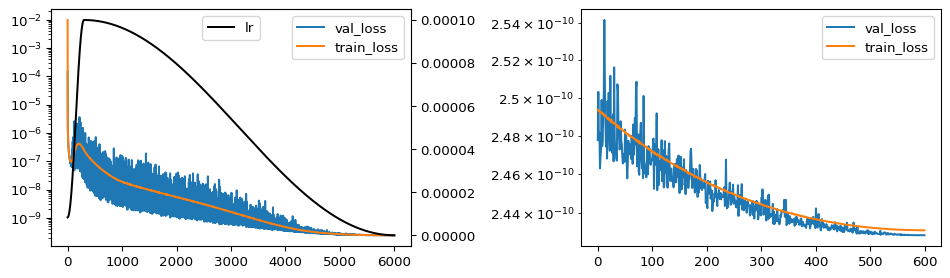

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(2.430932196265512e-10, 2.428343856973098e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 160.943233538419 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 98.70631383731961 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

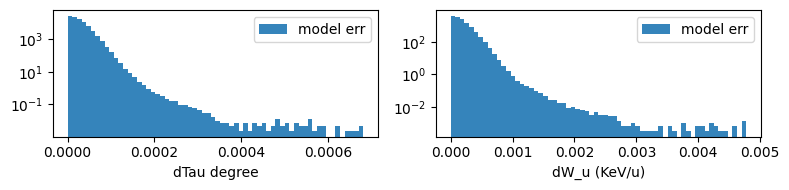

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)